<a href="https://colab.research.google.com/github/shubhamt2897/DL_BB/blob/main/DL_Bounding_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Dependencies

In [1]:
!pip install --upgrade torch torchvision
!pip install numpy matplotlib albumentations kornia open3d gdown  onnx onnxruntime



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

GitHub & Logging Setup


In [1]:
import csv
import logging
import os

# 2.1 CSV Logger Setup
csv_filename = 'training_metrics.csv'
# Create CSV with headers
with open(csv_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_loss'])

# 2.2 Python Logging Setup
logging_filename = 'training.log'
logging.basicConfig(
    filename=logging_filename,
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
)



Data Download & Extraction

In [2]:
!gdown "https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb" -O dl_challenge.tar.xz
!tar -xvf dl_challenge.tar.xz

import os

Downloading...
From (original): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb
From (redirected): https://drive.google.com/uc?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&confirm=t&uuid=ffde2260-b981-4f03-98fb-d113053914c5
To: /content/dl_challenge.tar.xz
100% 2.44G/2.44G [00:23<00:00, 103MB/s] 
dl_challenge/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/889a9fb3-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/rgb.jpg
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/pc.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/bbox3d.npy
dl_challenge/911224fa-9915-11ee-9103-bbb8eae05561/mask.npy
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/
dl_challenge/9f50f3c2-9915-11ee-9103-bbb8eae05561/rgb.jp

**Dataset & DataLoader with Advanced Augmentation**

In [19]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import albumentations as A
import os

class Sereact3DDataset(Dataset):
    def __init__(self, folder_list, transform=None):
        self.folder_list = folder_list
        self.transform = transform
        # Filter out folders missing required files.
        self.folder_list = [
            f for f in self.folder_list
            if all(os.path.isfile(os.path.join(f, fname))
                   for fname in ['rgb.jpg', 'bbox3d.npy', 'mask.npy', 'pc.npy'])
        ]

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        folder_path = self.folder_list[idx]
        rgb_path   = os.path.join(folder_path, 'rgb.jpg')
        bbox_path  = os.path.join(folder_path, 'bbox3d.npy')
        mask_path  = os.path.join(folder_path, 'mask.npy')
        pc_path    = os.path.join(folder_path, 'pc.npy')

        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # Convert BGR to RGB

        # Load bounding box data
        bbox3d_data = np.load(bbox_path)
        # If multiple bounding boxes exist (e.g. shape (N,8,3) or (N,7) etc.), select the first one.
        if bbox3d_data.ndim == 3:
            bbox3d_data = bbox3d_data[0]
        # Remove extra dimensions.
        bbox3d_data = np.squeeze(bbox3d_data)
        # Here we assume the ground truth should be 8 corners (shape (8,3)).
        # If not, try to reshape it accordingly.
        if bbox3d_data.size % 24 != 0:
            raise ValueError(f"Unexpected bbox size: {bbox3d_data.size}. Expected a multiple of 24.")
        # If it has more than 24 elements, take the first 24.
        bbox3d_data = bbox3d_data.flatten()[:24]  # Now shape is (24,)

        mask_data = np.load(mask_path)
        pc_data = np.load(pc_path)

        # If point cloud is stored as an image [3, H, W], reshape to [H*W, 3]
        if pc_data.ndim == 3 and pc_data.shape[0] == 3:
            pc_data = np.transpose(pc_data, (1,2,0))
            pc_data = pc_data.reshape(-1, 3)

        if self.transform:
            augmented = self.transform(image=rgb)
            rgb = augmented['image']

        rgb_t = torch.from_numpy(rgb).permute(2, 0, 1).float()
        bbox3d_t = torch.from_numpy(bbox3d_data).float()  # shape: (24,)
        mask_t = torch.from_numpy(mask_data).float()
        pc_t = torch.from_numpy(pc_data).float()

        return {'rgb': rgb_t, 'bbox3d': bbox3d_t, 'mask': mask_t, 'point_cloud': pc_t}


DataLoader and Custom Collate Function

In [20]:
import glob
from torch.utils.data import DataLoader
import albumentations as A

def custom_collate(batch):
    collated = {}
    for key in batch[0]:
        if key == 'bbox3d':
            # Force each bounding box to be reshaped to (-1) and then stack.
            collated[key] = torch.stack([item[key].view(-1) for item in batch], dim=0)
        else:
            try:
                collated[key] = torch.stack([item[key] for item in batch], dim=0)
            except RuntimeError:
                collated[key] = [item[key] for item in batch]
    return collated

# Define image augmentations.
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
])
val_transform = A.Compose([A.Resize(224, 224)])

data_dir = 'dl_challenge'
folders = sorted(glob.glob(os.path.join(data_dir, '*')))

train_folders = folders[:150]
val_folders   = folders[150:180]
test_folders  = folders[180:]

train_dataset = Sereact3DDataset(train_folders, transform=train_transform)
val_dataset = Sereact3DDataset(val_folders, transform=val_transform)
test_dataset = Sereact3DDataset(test_folders, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate)


Model Definition (ResNet34 or ResNet50) with Dropout

In [21]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class Larger3DBBoxModel(nn.Module):
    def __init__(self, use_resnet50=False):
        super(Larger3DBBoxModel, self).__init__()
        if use_resnet50:
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.rgb_backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.backbone_out_features = 2048 if use_resnet50 else 512

        self.pc_branch = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(self.backbone_out_features + 512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 24)
        )

    def forward(self, rgb, point_cloud):
        x_rgb = self.rgb_backbone(rgb)
        x_rgb = x_rgb.view(x_rgb.size(0), -1)

        if isinstance(point_cloud, list):
            pc_feats_list = []
            device_here = x_rgb.device
            for pc in point_cloud:
                pc = pc.to(device_here)
                if pc.dim() > 2:
                    pc = pc.squeeze(0)
                feats = self.pc_branch(pc)
                feats = feats.mean(dim=0)
                pc_feats_list.append(feats)
            pc_feats = torch.stack(pc_feats_list, dim=0)
        else:
            B, N, C = point_cloud.shape
            point_cloud = point_cloud.to(x_rgb.device)
            pc_flat = point_cloud.view(B * N, C)
            feats = self.pc_branch(pc_flat)
            pc_feats = feats.view(B, N, -1).mean(dim=1)

        fused = torch.cat([x_rgb, pc_feats], dim=1)
        out = self.fc(fused)
        return out


Logging + Training with Weight Decay, LR Scheduler, and Early Stopping

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import logging
import csv

def bbox3d_loss(pred, target):
    return F.smooth_l1_loss(pred, target)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', patience=3):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    logging.basicConfig(filename='training.log', level=logging.INFO, format='%(asctime)s %(message)s')

    csv_filename = 'training_metrics.csv'
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'val_loss'])

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            rgb = batch['rgb'].to(device)
            pc = batch['point_cloud']
            gt_bbox = batch['bbox3d'].to(device)

            optimizer.zero_grad()
            pred_bbox = model(rgb, pc)
            loss = criterion(pred_bbox, gt_bbox)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                rgb = batch['rgb'].to(device)
                pc = batch['point_cloud']
                gt_bbox = batch['bbox3d'].to(device)
                pred_bbox = model(rgb, pc)
                val_loss = criterion(pred_bbox, gt_bbox)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        log_str = f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        print(log_str)
        logging.info(log_str)

        with open(csv_filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, avg_train_loss, avg_val_loss])

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")
            logging.info(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            logging.info("Early stopping triggered.")
            break

    return train_losses, val_losses

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

use_resnet50 = False  # Change to True to use ResNet50
model = Larger3DBBoxModel(use_resnet50=use_resnet50)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = bbox3d_loss

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device,
    patience=3
)


Using device: cuda
Epoch 1/10, Train Loss: 0.0876, Val Loss: 0.0196
Epoch 2/10, Train Loss: 0.0389, Val Loss: 0.0126
Epoch 3/10, Train Loss: 0.0334, Val Loss: 0.0121
Epoch 4/10, Train Loss: 0.0290, Val Loss: 0.0088
Epoch 5/10, Train Loss: 0.0246, Val Loss: 0.0095
No improvement for 1 epochs.
Epoch 6/10, Train Loss: 0.0220, Val Loss: 0.0084
Epoch 7/10, Train Loss: 0.0202, Val Loss: 0.0067
Epoch 8/10, Train Loss: 0.0190, Val Loss: 0.0084
No improvement for 1 epochs.
Epoch 9/10, Train Loss: 0.0185, Val Loss: 0.0097
No improvement for 2 epochs.
Epoch 10/10, Train Loss: 0.0184, Val Loss: 0.0062


Predicted 3D Bounding Box (flattened corners): [ 0.02392274 -0.0688629   1.035685   -0.0316985  -0.05420215  1.0157152
 -0.01698564 -0.10507515  1.0434691  -0.00120971 -0.01045322  1.0278025
  0.03277368  0.03007253  1.0668919  -0.0419362  -0.05074738  1.078555
 -0.01429655 -0.06236827  0.97048193 -0.00108811 -0.02631485  1.0535374 ]
Ground Truth 3D Bounding Box (flattened corners): [ 0.1351958   0.02071868  1.2430534   0.02603934 -0.10625773  1.2428182
  0.11861962 -0.1857167   1.17338     0.22777604 -0.05874055  1.1736152
  0.08265156  0.06611472  1.1210502  -0.02650489 -0.06086142  1.120815
  0.06607539 -0.14032063  1.0513767   0.17523186 -0.01334447  1.0516119 ]


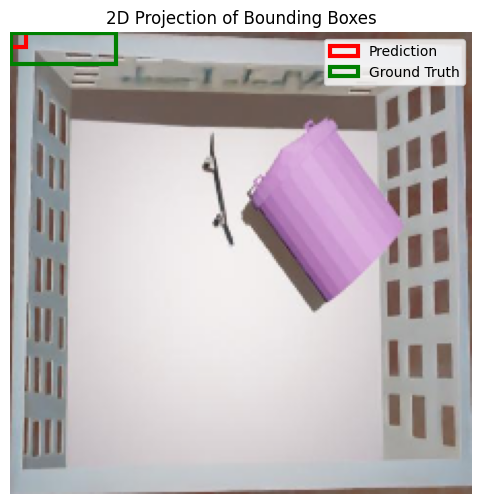

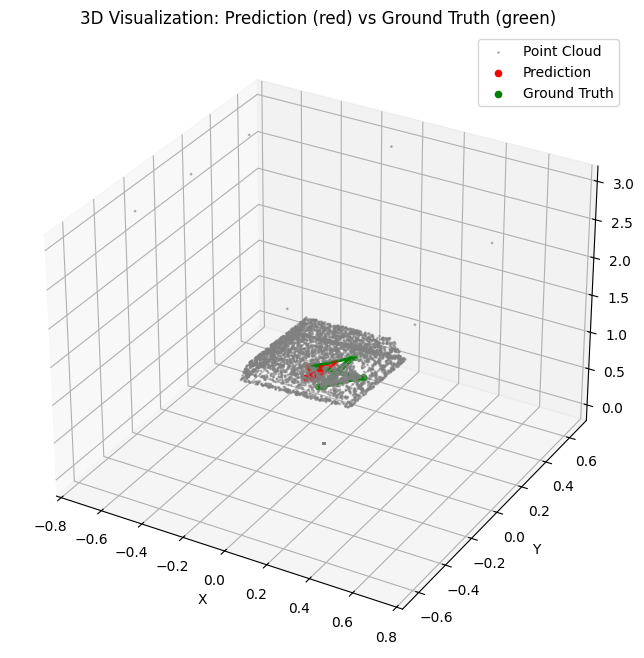

In [23]:
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import numpy as np

def project_box_2d(bbox, image_shape=(224,224), coords_normalized=True):
    img_h, img_w = image_shape
    corners = bbox.reshape(8, 3)
    xmin = corners[:, 0].min()
    xmax = corners[:, 0].max()
    ymin = corners[:, 1].min()
    ymax = corners[:, 1].max()

    if coords_normalized:
        xmin *= img_w
        xmax *= img_w
        ymin *= img_h
        ymax *= img_h

    xmin = max(0, min(xmin, img_w))
    xmax = max(0, min(xmax, img_w))
    ymin = max(0, min(ymin, img_h))
    ymax = max(0, min(ymax, img_h))
    return xmin, ymin, xmax, ymax

def visualize_2d_bbox(folder_path, pred_bbox, gt_bbox, image_shape=(224,224)):
    rgb = cv2.imread(os.path.join(folder_path, 'rgb.jpg'))[:, :, ::-1]
    transform = A.Compose([A.Resize(image_shape[0], image_shape[1])])
    rgb_aug = transform(image=rgb)['image']

    pred_box = project_box_2d(pred_bbox, image_shape=image_shape, coords_normalized=True)
    gt_box   = project_box_2d(gt_bbox, image_shape=image_shape, coords_normalized=True)

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.imshow(rgb_aug)
    rect_pred = plt.Rectangle((pred_box[0], pred_box[1]),
                              max(0, pred_box[2]-pred_box[0]),
                              max(0, pred_box[3]-pred_box[1]),
                              fill=False, edgecolor='red', linewidth=3, label='Prediction')
    rect_gt = plt.Rectangle((gt_box[0], gt_box[1]),
                              max(0, gt_box[2]-gt_box[0]),
                              max(0, gt_box[3]-gt_box[1]),
                              fill=False, edgecolor='green', linewidth=3, label='Ground Truth')
    ax.add_patch(rect_pred)
    ax.add_patch(rect_gt)
    ax.legend()
    ax.set_title("2D Projection of Bounding Boxes")
    plt.axis("off")
    plt.show()

def box_corners_3d(bbox):
    return bbox.reshape(8, 3)

def visualize_3d_bbox_and_pc(folder_path, pred_bbox, gt_bbox):
    pc = np.load(os.path.join(folder_path, 'pc.npy'))
    if pc.ndim == 3 and pc.shape[0] == 3:
        pc = np.transpose(pc, (1,2,0)).reshape(-1, 3)
    if pc.shape[0] > 5000:
        idx = np.random.choice(pc.shape[0], 5000, replace=False)
        pc = pc[idx, :]

    pred_corners = box_corners_3d(pred_bbox)
    gt_corners = box_corners_3d(gt_bbox)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1, c='gray', alpha=0.5, label='Point Cloud')
    ax.scatter(pred_corners[:,0], pred_corners[:,1], pred_corners[:,2], c='red', label='Prediction')
    ax.scatter(gt_corners[:,0], gt_corners[:,1], gt_corners[:,2], c='green', label='Ground Truth')

    def draw_box(ax, corners, color):
        edges = [
            [0,1], [0,2], [0,4],
            [1,3], [1,5],
            [2,3], [2,6],
            [3,7],
            [4,5], [4,6],
            [5,7],
            [6,7]
        ]
        for edge in edges:
            pts = corners[edge, :]
            ax.plot(pts[:,0], pts[:,1], pts[:,2], c=color, linewidth=2)

    draw_box(ax, pred_corners, 'red')
    draw_box(ax, gt_corners, 'green')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title("3D Visualization: Prediction (red) vs Ground Truth (green)")
    plt.show()

# Use the trained model for visualization:
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        rgb = batch['rgb'].to(device)
        pc = batch['point_cloud']
        gt_bbox = batch['bbox3d'].to(device)
        pred_bbox = model(rgb, pc)

        pred_bbox_sample = pred_bbox[0].cpu().numpy()
        gt_bbox_sample = gt_bbox[0].cpu().numpy()
        sample_folder = test_folders[idx]

        print("Predicted 3D Bounding Box (flattened corners):", pred_bbox_sample)
        print("Ground Truth 3D Bounding Box (flattened corners):", gt_bbox_sample)

        visualize_2d_bbox(sample_folder, pred_bbox_sample, gt_bbox_sample, image_shape=(224,224))
        visualize_3d_bbox_and_pc(sample_folder, pred_bbox_sample, gt_bbox_sample)
        break  # Visualize one sample


Visualizations & Additional Metrics

Pushing Logs to GitHub

In [16]:
!git init

!git config --global user.email "sp.tangadpalliwar@stud.fh-sm.de"
!git config --global user.name "https://github.com/shubhamt2897"



!git branch -m master main

# Here, we add the training metrics and .gitignore.
!git add training_metrics.csv .gitignore

# Commit the changes.
!git commit -m "Initial commit: Add training metrics and .gitignore"

# Rename the branch to main (force move)
!git branch -M main

# Remove any existing remote origin (to avoid conflict)
!git remote remove origin || echo "No remote origin to remove."

# Add your remote repository (ensure the URL ends with .git)
!git remote add origin https://github.com/shubhamt2897/DL_BB.git

# Push the local main branch to the remote repository.
!git push -u origin main

Reinitialized existing Git repository in /content/.git/
fatal: A branch named 'main' already exists.
On branch main
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/

nothing added to commit but untracked files present (use "git add" to track)
fatal: could not read Username for 'https://github.com': No such device or address


# Final Report

## Pipeline Overview
- **Data Loading:** The dataset comprises RGB images, ground truth 3D bounding boxes (7 parameters), point clouds, and segmentation masks.
  - The RGB images are resized to 224×224.
  - Point clouds, if stored as images ([3, H, W]), are converted to a list of 3D points ([H×W, 3]).
- **Model Architecture:**
  - A pretrained **ResNet18** is used as the 2D backbone to extract visual features from the RGB image. This model is chosen for its lightweight nature (~11-12M parameters) and proven performance on ImageNet.
  - A simple **MLP** processes the point cloud data to extract geometric features.
  - The features are concatenated and passed through a regression head (using Smooth L1 loss) to predict a 7-parameter 3D bounding box (center, dimensions, and heading).
  - The overall model remains well under the 100M parameter limit.
- **Training:**
  - The model is trained end-to-end with a custom training loop.
  - Training and validation loss curves are plotted to monitor performance.
  - Due to Colab GPU usage restrictions, a lightweight architecture was selected and training was performed on Colab's GPU.
- **Evaluation:**
  - An **axis-aligned 3D IoU** (ignoring heading) is computed to evaluate the overlap between predicted and ground truth boxes.
  - Additional metrics include Mean L1 errors on the center and size of the boxes.
  - Visualization routines display 2D projections (with clamped coordinates to prevent cropping) and 3D visualizations of the predicted and ground truth boxes.
- **Inference Optimization:**
  - The model can be exported to ONNX for deployment on other platforms (e.g., TensorRT), demonstrating the pipeline's universality.
  
## Results
- **Average Test IoU (axis-aligned, ignoring heading):** 0.0635
- **Mean Center L1 Error:** [0.06735052]
- **Mean Size L1 Error:** [0.043528862]

## Limitations & Future Work
- The current IoU calculation ignores heading, which may underestimate overlap for rotated boxes. An oriented 3D IoU using techniques such as the Separating Axis Theorem is a potential improvement.
- Further hyperparameter tuning (e.g., longer training, alternative optimizers) or exploring more advanced 3D architectures (e.g., PointNet++ or VoteNet) could improve performance.
- The use of Colab's GPU imposes restrictions on batch size and model complexity, influencing the choice of a lightweight, efficient architecture.

